# MBA em Ciência de Dados
## Técnicas Avançadas de Captura e Tratamento de Dados

### <span style="color:darkred">Módulo VII - Dados não estruturados: sinais e imagens</span>

### <span style="color:darkred">Embeddings de imagens a partir de modelos de redes neurais pré-treinados</span>

Material Produzido por Moacir Antonelli Ponti

CeMEAI - ICMC/USP São Carlos

---

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

---
Iremos usar a função do tensorflow `image_dataset_from_directory` para carregar os dados. É preciso organizar os dados em pastas no formato:
- ./train para o treinamento
- ./test para o conjunto de teste
- também podemos adicionar outras como conjunto de validação, etc.

Adicionalmente, dentro de cada pasta, dividimos os dados em pastas para cada classe. Nesse exemplo as pastas são numéricas, classes 0 e 1

Podemos passar argumentos para essa função incluindo:
- `batch_size`: o agrupamento de imagens para procesamento em lote, ex. 32 por vez
- `shuffle`: se gostaríamos de carregar as imagens e embaralhá-las
- `label_mode`: qual o formato esperado do rótulo, ex. inteiro
- `image_size`: o tamanho pré-definido das imagens. Note que redes neurais necessitam que todas sejam do mesmo tamanho.

Nesse notebook usaremos o dataset 'Dogs vs Cats', mas você pode substituir pelo dataset que quiser para realizar a extração de características
- https://www.kaggle.com/c/dogs-vs-cats

In [2]:
def load_dataset_as_numpy(directory, batch_size=32, image_size=(150, 150), shuffle=True, seed=1):
    # Carrega o conjunto de dados como um objeto tf.data.Dataset
    dataset = tf.keras.preprocessing.image_dataset_from_directory(
        directory,
        labels='inferred',
        label_mode='int',
        batch_size=batch_size,
        image_size=image_size,
        shuffle=shuffle,
        seed=seed
    )

    # Inicializa listas vazias para armazenar imagens e rótulos
    images_list = []
    labels_list = []

    # Itera sobre o conjunto de dados
    for images, labels in dataset:
        # Adiciona os lotes de imagens e rótulos às listas
        images_list.append(images)
        labels_list.append(labels)

    # Concatena os lotes em um único array numpy para imagens e rótulos
    images_np = np.concatenate(images_list, axis=0)
    labels_np = np.concatenate(labels_list, axis=0)

    return images_np, labels_np

In [3]:
# Carrega imagens de diretórios e aplica pré-processamento
print('Carregando conjunto de treinamento...' )

# Exemplo de uso da função
ds_train_images, ds_train_labels = load_dataset_as_numpy('image_dataset2/train')

# Verifica as formas dos arrays resultantes
print("Shape do array de imagens:", ds_train_images.shape)
print("Shape do array de rótulos:", ds_train_labels.shape)
print()

# Exemplo de uso da função
ds_test_images, ds_test_labels = load_dataset_as_numpy('image_dataset2/test')

# Verifica as formas dos arrays resultantes
print("Shape do array de imagens:", ds_test_images.shape)
print("Shape do array de rótulos:", ds_test_labels.shape)

Carregando conjunto de treinamento...


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 38: invalid continuation byte

---
## Modelos pré-treinados

São modelos de Deep Learning treinados em grandes quantidades de dados (nesse caso bases de dados de imagens) e que, por terem grande complexidade e terem sido pré-treinados com muitas imagens, podem ser utilizados para realizar *transferência de aprendizado*.

> A *transferência de aprendizado* é um processo no qual aproveitamos um modelo treinado com dados diferentes dos quais estamos trabalhando, mas que possuem capacidade de generalizar.

Nesse notebook vamos usar um modelo de Rede Neural Convolucional com boa relação entre velocidade e qualidade, chamado **Xception**.


O modelo será usado como um extrator de características, ou seja, extrairemos um vetor numérico de uma camada interna da rede neural. Essa representação vetorial é comumente chamada de **embedding** (ou em Português imersão).

> Com os embeddings formamos um dataset de características da nossa base de imagens que podem ser usadas para treinar classificadores ou para qualquer outra tarefa

Outros modelos podem ser usados conforme lista em: https://keras.io/api/applications/

In [ ]:
# Funcao para extrair os labels apenas
def extract_labels(image, label):
    return label

# Obter os labels
ds_train_labels = ds_train.map(extract_labels)
ds_test_labels = ds_test.map(extract_labels)

# converter para numpy array
# aqui convertemos para lista e depois concatenamos (já que a lista vai conter os lotes de 32 em 32 rótulos)
train_labels = np.concatenate(list(ds_train_labels))
test_labels = np.concatenate(list(ds_test_labels))

In [ ]:
train_labels[:9], test_labels[:9]

(array([1, 0, 0, 1, 1, 1, 0, 1, 0], dtype=int32),
 array([0, 0, 0, 0, 1, 1, 1, 1, 0], dtype=int32))

In [ ]:
train_labels.shape, test_labels.shape

((4687,), (1200,))

### 1. Exibindo imagens

In [ ]:
def show_images(images, labels, num_images=10):
    # Garante que o número de imagens a serem exibidas não excede o tamanho do conjunto de dados
    num_images = min(num_images, len(images))

    # Cria uma figura com subplots
    fig, axes = plt.subplots(1, num_images, figsize=(15, 15))

    # Exibe as imagens e seus rótulos correspondentes
    for i in range(num_images):
        axes[i].imshow(images[i].astype("uint8"))  # Converte para o tipo de dados uint8 para exibição correta
        axes[i].set_title(labels[i])
        axes[i].axis("off")

    plt.show()

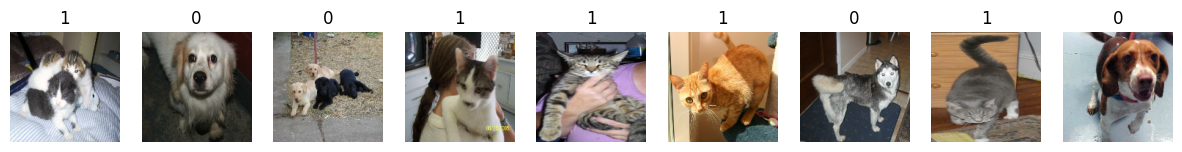

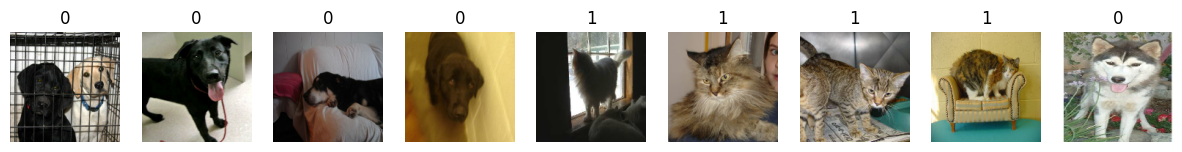

In [ ]:
show_images(ds_train_images, ds_train_labels, num_images=9)

# Exibe as 10 primeiras imagens do conjunto de teste e seus rótulos
show_images(ds_test_images, ds_test_labels, num_images=9)

In [ ]:
dic_label = {0:'dog', 1:'cat'}

### 2. Carregar Modelo Pré-treinado e montar Modelo Extrator

Carregamos o modelo `Xception`.

- `include_top`: indica se vamos carregar o modelo completo, ou se desejamos apenas o extrator de características. Nesse caso como queremos apenas as características (embedding) usamos `False`
- `weights`: indica os pesos/parâmetros que gostaríamos de carregar do modelo. Nesse caso vamos usar os pesos treinados na base de dados imagenet
- `input_shape`: indica o formato de entrada das imagens

In [ ]:
# Carrega um modelo base, sem incluir o classificador (include_top = False)
# esse modelo foi pretreinado na ImageNet
base_model = tf.keras.applications.Xception(include_top=False,
                                               weights='imagenet',
                                               input_shape=(150, 150, 3))

Após carregar o modelo, montamos um extrator de características usando:
- uma camada de entrada
- uma camada de pré-processamento
- o modelo base (Xception)
- uma camada de pós-processamento chamada `GlobalAveragePooling2D`, que irá tomar as features geradas pelo Xception e obter um único valor para cada feature 2D.

Finalmente, montamos o modelo como possuindo imagens de entrada e features como saída

In [ ]:
# desde a entrada (formato da imagem) até as features de saída
inputs = tf.keras.Input(shape=(150, 150, 3))
x = tf.keras.applications.xception.preprocess_input(inputs)
x = base_model(x)
features = tf.keras.layers.GlobalAveragePooling2D()(x)

# modelo
model_extract_features = tf.keras.Model(inputs, features)

### 3. Extração das características

Realizamos uma predição no modelo (com `predict`), mas como esse modelo é um extrator de features, vai nos retornar apenas *tensores* contendo as características para cada imagem. Tensores são arrays de vetores e são típicos em modelos de Deep Learning

In [ ]:
# Como o modelo não tem a camada de classificacao,
# o predict aqui nos gera como saída os embeddings
embeddings_train = model_extract_features.predict(ds_train_images)
embeddings_test = model_extract_features.predict(ds_test_images)

2024-05-05 14:43:41.725397: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1265490000 exceeds 10% of free system memory.


38/38 [==============================] - 19s 490ms/step


In [ ]:
# Agora "achatamos" o resultado pois queremos vetores e não tensores

features_train = embeddings_train.reshape(len(embeddings_train), -1)
features_test = embeddings_test.reshape(len(embeddings_test), -1)

In [ ]:
features_train.shape, features_test.shape

((4687, 2048), (1200, 2048))

Note a dimensionalidade dos embeddings.

Podemos visualizar esses embeddings em 2D utilizando algum método de projeção.

O TSNE é um dos mais utilizados, conforme exemplo abaixo, iremos exibir apenas os primeiros 1000 exemplos de treinamento.

In [ ]:
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(features_train[:1000])

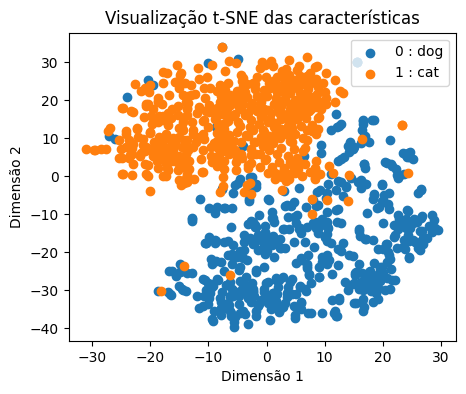

In [ ]:
# Obtem os rótulos únicos
unique_labels = np.unique(ds_train_labels)

# Plota o t-SNE
plt.figure(figsize=(5, 4))
for label in unique_labels:
    # Seleciona os embeddings e os rótulos correspondentes para a classe atual
    embeddings_class = embeddings_2d[ds_train_labels[:1000] == label]
    label_name = str(label) + ' : ' + str(dic_label[label])  # Ajuste conforme necessário

    # Plota os pontos correspondentes à classe atual
    plt.scatter(embeddings_class[:, 0], embeddings_class[:, 1], label=label_name)

plt.title('Visualização t-SNE das características')
plt.xlabel('Dimensão 1')
plt.ylabel('Dimensão 2')
plt.legend()
plt.show()

### 4. Aplicando as features obtidas em um classificador

Em geral segue os seguintes passos:

1. Redução da dimensonalidade, por exemplo via PCA (Principal Component Analysis): esse passo pode ser relevante para permitir trabalhar com espaços de características mais reduzidos.

2. Treinamento do classificador. Aqui vamos usar Logistic Regression e SVM como exemplo.

#### 4.1 Usando features originais (2048 dimensões)

- Logistic Regression
- SVM

In [ ]:
logreg_classifier = LogisticRegression(max_iter=1000)
logreg_classifier.fit(features_train, train_labels)

LogisticRegression(max_iter=1000)

In [ ]:
# Avaliando o classificador
predictions = logreg_classifier.predict(features_test)
accuracy = accuracy_score(test_labels, predictions)
print(f"Test accuracy: {accuracy*100}%")

Test accuracy: 97.08333333333333%


In [ ]:
clf = SVC()
clf.fit(features_train, train_labels)

# Avaliando o classificador
predictions = clf.predict(features_test)
accuracy = accuracy_score(test_labels, predictions)
print(f"Test accuracy: {accuracy*100}%")

Test accuracy: 97.0%


#### 4.2 Usando features reduzidas (256 dimensões)

- Redução com PCA
- Treinamento com SVM

In [ ]:
# PCA para reduzir a dimensionalidade
pca = PCA(n_components=256)
pca.fit(features_train)

# Transformacao e obtencao dos componentes principais
compressed_features_train = pca.transform(features_train)
compressed_features_test = pca.transform(features_test)

In [ ]:
clf = SVC()
clf.fit(compressed_features_train, train_labels)

# Avaliando o classificador
predictions = clf.predict(compressed_features_test)
accuracy = accuracy_score(test_labels, predictions)
print(f"Test accuracy: {accuracy*100}%")

Test accuracy: 97.0%
